In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
dataroot = '../input/celeba-dataset/img_align_celeba'
workers = 2
batch_size = 128
image_size = 64
nc = 3          #number of channels in training images

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 7

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
dataset = dset.ImageFolder(root = dataroot , transform = transforms.Compose([transforms.Resize(image_size),
                                                                            transforms.CenterCrop(image_size),
                                                                             transforms.ToTensor(),
                                                                             transforms.Normalize((0.5,0.5,0.5) , (0.5,0.5,0.5))]))

dataLoader = torch.utils.data.DataLoader(dataset,batch_size = batch_size , shuffle = True,num_workers = workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

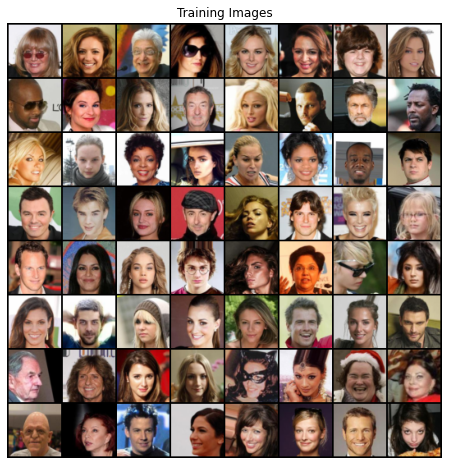

In [4]:
real_batch = next(iter(dataLoader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
def weights_init(m):
    class_name = m.__class__.__name__
    if not(class_name.find('Conv') == -1):
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif not(class_name.find('BatchNorm') == -1):
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)
    

In [6]:
class Generator(nn.Module):
    def __init__(self,ngpu):
        super(Generator,self).__init__()
        self.ngpu = ngpu
        self.conv1 = nn.ConvTranspose2d(nz,ngf*8,kernel_size = 4 , stride = 1, padding = 0,bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        self.conv2 = nn.ConvTranspose2d(ngf*8,ngf*4 , kernel_size = 4 , stride = 2 , padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(ngf*4)
        self.conv3 = nn.ConvTranspose2d(ngf*4,ngf*2 , kernel_size = 4 , stride = 2 , padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(ngf*2)
        
        self.conv4 = nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        
        self.conv5 = nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False)
        
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        return F.tanh(x)
        
        

In [7]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)


Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator,self).__init__()
        self.ngpu = ngpu
        self.conv1 = nn.Conv2d(nc,ndf,kernel_size = 4, stride = 2 , padding = 1,bias = False)
        self.act1 = nn.LeakyReLU(0.2 , inplace = True)
        
        self.conv2 = nn.Conv2d(ndf,ndf*2,kernel_size = 4, stride = 2 , padding = 1,bias = False)
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.act2 = nn.LeakyReLU(0.2 , inplace = True)
        
        self.conv3 = nn.Conv2d(ndf*2,ndf*4,kernel_size = 4, stride = 2 , padding = 1,bias = False)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.act3 = nn.LeakyReLU(0.2 , inplace = True)
        
        self.conv4 = nn.Conv2d(ndf*4,ndf*8,kernel_size = 4, stride = 2 , padding = 1,bias = False)
        self.bn4 = nn.BatchNorm2d(ndf*8)
        self.act4 = nn.LeakyReLU(0.2 , inplace = True)
        
        self.conv5 = nn.Conv2d(ndf*8,1,kernel_size = 4, stride = 1, padding = 0, bias=False)
    
    def forward(self,x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.act4(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        
        return F.sigmoid(x)
    
    
        
        
    

In [9]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)


Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (act1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [10]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64,nz,1,1,device = device)
real_label = 1
fake_label = 0

optimizer_D = optim.Adam(netD.parameters(),lr=lr,betas = (beta1,0.999))
optimizer_G = optim.Adam(netG.parameters(),lr=lr,betas = (beta1,0.999))




In [11]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training")

for epoch in range(num_epochs):
    
    for i,data in enumerate(dataLoader,0):
        
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        label = torch.full((b_size,) , real_label)
        label = label.to(device)
        
        output = netD(real_cpu).view(-1)
        
        err_D_real = criterion(output,label)
        
        err_D_real.backward()
        
        noise = torch.randn(b_size,nz,1,1,device = device)
        fake_image = netG(noise)
        
        label.fill_(fake_label)
        output2 = netD(fake_image.detach()).view(-1)
        
        err_D_fake = criterion(output2,label)
        
        err_D_fake.backward()
        
        err_D = err_D_real + err_D_fake
        
        optimizer_D.step()
        
        netG.zero_grad()
        label.fill_(real_label)
        output3 = netD(fake_image).view(-1)
        err_G = criterion(output3,label)
        
        err_G.backward()
        
        optimizer_G.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataLoader),
                     err_D.item(), err_G.item()))

        # Save Losses for plotting later
        G_losses.append(err_G.item())
        D_losses.append(err_D.item())
        
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataLoader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        
        
        
        
    
    

Starting Training


/opt/conda/conda-bld/pytorch_1591914880026/work/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/7][0/1583]	Loss_D: 1.7771	Loss_G: 6.4739
[0/7][50/1583]	Loss_D: 0.2207	Loss_G: 20.6864
[0/7][100/1583]	Loss_D: 0.1794	Loss_G: 5.1707
[0/7][150/1583]	Loss_D: 0.3582	Loss_G: 4.4809
[0/7][200/1583]	Loss_D: 0.4205	Loss_G: 4.9047
[0/7][250/1583]	Loss_D: 0.5704	Loss_G: 4.3866
[0/7][300/1583]	Loss_D: 0.4736	Loss_G: 4.0076
[0/7][350/1583]	Loss_D: 0.8444	Loss_G: 8.1262
[0/7][400/1583]	Loss_D: 0.3968	Loss_G: 4.6749
[0/7][450/1583]	Loss_D: 0.5078	Loss_G: 3.5281
[0/7][500/1583]	Loss_D: 0.3598	Loss_G: 3.9592
[0/7][550/1583]	Loss_D: 0.5213	Loss_G: 5.0497
[0/7][600/1583]	Loss_D: 0.6477	Loss_G: 6.0710
[0/7][650/1583]	Loss_D: 0.2296	Loss_G: 3.4135
[0/7][700/1583]	Loss_D: 0.3803	Loss_G: 5.5198
[0/7][750/1583]	Loss_D: 0.2615	Loss_G: 5.4484
[0/7][800/1583]	Loss_D: 0.4866	Loss_G: 4.2610
[0/7][850/1583]	Loss_D: 0.3283	Loss_G: 5.3829
[0/7][900/1583]	Loss_D: 1.0021	Loss_G: 7.4225
[0/7][950/1583]	Loss_D: 1.3920	Loss_G: 5.2321
[0/7][1000/1583]	Loss_D: 0.4708	Loss_G: 4.9787
[0/7][1050/1583]	Loss_D: 0.3568	Los

[5/7][900/1583]	Loss_D: 0.5999	Loss_G: 3.3021
[5/7][950/1583]	Loss_D: 0.5587	Loss_G: 1.9480
[5/7][1000/1583]	Loss_D: 0.7709	Loss_G: 1.0791
[5/7][1050/1583]	Loss_D: 0.5856	Loss_G: 3.7049
[5/7][1100/1583]	Loss_D: 0.4783	Loss_G: 2.3820
[5/7][1150/1583]	Loss_D: 0.7558	Loss_G: 4.6823
[5/7][1200/1583]	Loss_D: 0.6282	Loss_G: 3.8728
[5/7][1250/1583]	Loss_D: 1.0368	Loss_G: 4.0352
[5/7][1300/1583]	Loss_D: 0.4991	Loss_G: 1.8572
[5/7][1350/1583]	Loss_D: 0.8882	Loss_G: 4.1303
[5/7][1400/1583]	Loss_D: 0.7382	Loss_G: 1.5060
[5/7][1450/1583]	Loss_D: 0.6541	Loss_G: 1.0337
[5/7][1500/1583]	Loss_D: 1.8133	Loss_G: 5.1724
[5/7][1550/1583]	Loss_D: 0.4370	Loss_G: 3.0823
[6/7][0/1583]	Loss_D: 0.5301	Loss_G: 3.4814
[6/7][50/1583]	Loss_D: 0.9088	Loss_G: 0.8987
[6/7][100/1583]	Loss_D: 0.4048	Loss_G: 2.3339
[6/7][150/1583]	Loss_D: 1.2167	Loss_G: 1.1404
[6/7][200/1583]	Loss_D: 0.6370	Loss_G: 2.6198
[6/7][250/1583]	Loss_D: 1.3470	Loss_G: 0.8621
[6/7][300/1583]	Loss_D: 0.5797	Loss_G: 1.5796
[6/7][350/1583]	Loss_D: 0

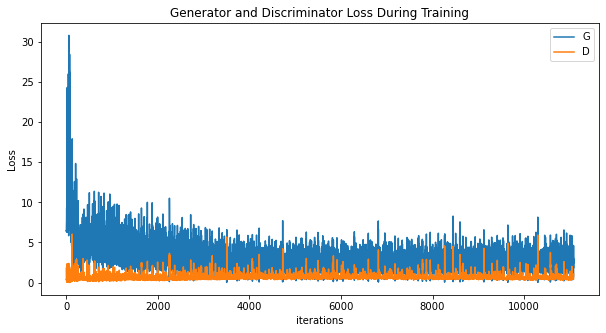

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

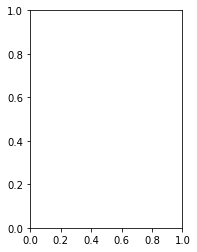

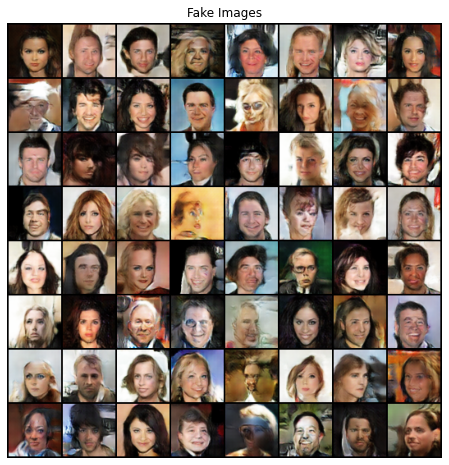

In [14]:
plt.subplot(1,2,2)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
